Customer feedback appears across many channels including social media and partner websites.  We want to capture this valuable product feedback to spot negative trends and improve the situation, if needed. Here we will train a model to classify the feedback messages into positive (1) and negative (0) sentiment.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#import csv as dataframe
path = "datasets/steam_reviews.csv"
df = pd.read_csv(path, delimiter=",")
df.head()

,title,review_text,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count
0,Destiny_2,free to play but not free to enjoy,1643914192,True,732,102,0.934972,0
1,Destiny_2,I want Mara Sov to stomp me,1643418367,True,678,230,0.879497,25
2,Destiny_2,It's not a game it's a job,1643432021,False,421,108,0.816016,0
3,Destiny_2,Horrible Game,1644883764,True,200,183,0.783575,0
4,Destiny_2,I have spent an ungodly amount of time on this...,1644288799,True,91,65,0.781530,0


In [2]:
data = df[["review_text","voted_up"]].rename(columns = {"voted_up":"sentiment"})
pd.set_option("display.max_colwidth",None)
display(data.head())
data.info()

,review_text,sentiment
0,free to play but not free to enjoy,True
1,I want Mara Sov to stomp me,True
2,It's not a game it's a job,False
3,Horrible Game,True
4,"I have spent an ungodly amount of time on this game. Every time I load the starting screen ask myself the same question...""Why?"". I later come to the same conclusion after I rage quit from playing trials, iron banner, or the crucible. After being skull fucked into oblivion for the millionth time, by a team of shotgunning apes, that conclusion is simply put. It is because i hate myself. I like to consider myself a calm and collected human being but after i play a match of trials its as if I have the overwhelming feeling to know what a shotgun shell taste like. The only thing that makes the pvp so bad in this game is the developers have no concept of matchmaking and the communities incessant need to gate keep the tower. One match you will feel like the people you are playing against are about your skill level. The next match, and every match after that, you will be matched with people that have not seen the sunlight since their mom drove them home from the hospital from their birth. If there was an exotic quest for going outside I think they would be incapable of such a feat just due to the fact they cannot get out of their chair, have you seen the south park episode where they play WoW, that is them. The only redeeming quality this game does have is blind running a dungeon and or raid. Afterwards, you just feel this emptiness because the game has this really bad practice of having the player drain their life away to find an exotic weapon where they have the off chance of acquiring. Ever heard of the Vex Mythoclast? Me neither. Do I recommend this game? Yes, if you live in your parents basement and literally having to do with your life, then fuck yeah please go for it, you fuck. Otherwise, no, you would have better time going to college, getting a degree, finding a girlfriend, getting cheated on, then finding another, getting married, having kids, having a mortgage, taking loans, getting insane credit card debt, and then finally dying before stumbling across the Vex.",True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32985 entries, 0 to 32984
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  32936 non-null  object
 1   sentiment    32985 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 290.0+ KB


In [3]:
#preprocess function
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) 
def text_preprocess(text,num):
    
    new_string = text.lower() #lowercase text
    
    new_string = BeautifulSoup(new_string, "lxml").text #remove html tags
    
    new_string = re.sub(r'\([^)]*\)', '', new_string) #remove parentheses
    new_string = re.sub('"','', new_string)   
    new_string = re.sub(r"'s\b","",new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string) 
    new_string = re.sub('[m]{2,}', 'mm', new_string)
    if(num==0):
        tokens = [w for w in new_string.split() if not w in stopwords]
    else:
        tokens=new_string.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

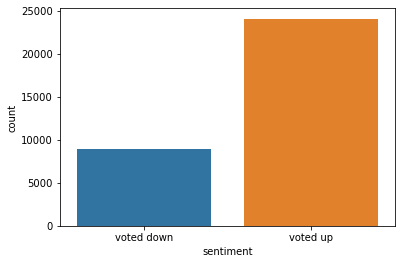

In [4]:
#check class balance of sentiment
cb = sns.countplot(data["sentiment"])
cb.set_xticklabels(["voted down", "voted up"])
plt.show()

In [5]:
#review text preprocessing
data.drop_duplicates(subset=['review_text'], inplace=True) 
data.dropna(axis=0, inplace=True) 
data['review_text'] = data['review_text'].apply(lambda x: text_preprocess(x,0)) #apply method does not support inplace argument
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x else 0) #convert target to binary int

#display cleaned data
data.head(5)

,review_text,sentiment
0,free play free enjoy,1
1,want mara sov stomp,1
2,game job,0
3,horrible game,1
4,spent ungodly amount time game every time load starting screen ask question later come conclusion rage quit playing trials iron banner crucible skull fucked oblivion millionth time team shotgunning apes conclusion simply put hate like consider calm collected human play match trials overwhelming feeling know shotgun shell taste like thing makes pvp bad game developers concept matchmaking communities incessant need gate keep tower one match feel like people playing skill level next match every match matched people seen sunlight since mom drove home hospital birth exotic quest going outside think would incapable feat due fact cannot get chair seen south park episode play wow redeeming quality game blind running dungeon raid afterwards feel emptiness game really bad practice player drain life away find exotic weapon chance acquiring ever heard vex mythoclast neither recommend game yes live parents basement literally life fuck yeah please go fuck otherwise would better time going college getting degree finding girlfriend getting cheated finding another getting married kids mortgage taking loans getting insane credit card debt finally dying stumbling across vex,1


In [6]:
import random
#randomly down-sample majority class since the dataset is large
random.seed(37)
minority_class = data[data["sentiment"] ==0]
majority_class = data[data["sentiment"] ==1]
sliced_index = random.choices((majority_class.index), k=len(minority_class)) #randomly choose index list
data= pd.concat([majority_class.loc[sliced_index], minority_class]).reset_index(drop=True) #concatenate two classes

#display down-sampled data
data.head()

,review_text,sentiment
0,standwithukraine war fuckthewar ukraine,1
1,grr,1
2,convinced game somehow reversing entropy,1
3,week hours pretty normal,1
4,recommend game really enjoy going bed mad waking instantly getting touch inner rage fuckin hate self whatever reason good way keep humble fantastically toxic community,1


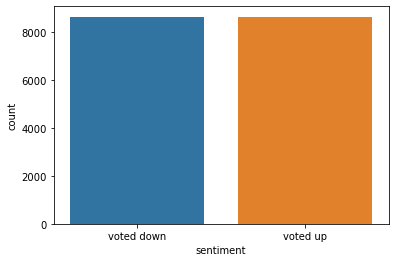

In [7]:
#check class balance again
cb2 = sns.countplot(data["sentiment"])
cb2.set_xticklabels(["voted down", "voted up"])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
# split all data into 90% train and 10% holdout
test_size = 0.1
x_train, x_test, y_train, y_test = train_test_split(data['review_text'],
                                                   data['sentiment'],
                                                   test_size=test_size,
                                                   stratify=data['sentiment'])
print('size of trainset: {}\nsize of testset: {}'.format(len(x_train.index), len(x_test.index)))

size of trainset: 15552
size of testset: 1728


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding
from keras import initializers

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

vocab_size = len(tokenizer.word_index) + 1
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=200)
x_test = pad_sequences(x_test, maxlen=200)
embedding_vector_length = 32

In [10]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model_LSTM.add(SpatialDropout1D(0.25))
model_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           844864    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 861,515
Trainable params: 861,515
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model_LSTM.fit(x_train,y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
389/389 [==============================] - 46s 117ms/step - loss: 0.5619 - accuracy: 0.7032 - val_loss: 0.4580 - val_accuracy: 0.7878
Epoch 2/10
389/389 [==============================] - 45s 116ms/step - loss: 0.3982 - accuracy: 0.8218 - val_loss: 0.4281 - val_accuracy: 0.8110
Epoch 3/10
389/389 [==============================] - 50s 129ms/step - loss: 0.3534 - accuracy: 0.8519 - val_loss: 0.4307 - val_accuracy: 0.8126
Epoch 4/10
389/389 [==============================] - 53s 136ms/step - loss: 0.3189 - accuracy: 0.8655 - val_loss: 0.4350 - val_accuracy: 0.8116
Epoch 5/10
389/389 [==============================] - 56s 145ms/step - loss: 0.2990 - accuracy: 0.8764 - val_loss: 0.4457 - val_accuracy: 0.8132
Epoch 6/10
389/389 [==============================] - 54s 138ms/step - loss: 0.2832 - accuracy: 0.8838 - val_loss: 0.4492 - val_accuracy: 0.8177
Epoch 7/10
389/389 [==============================] - 52s 134ms/step - loss: 0.2731 - accuracy: 0.8885 - val_loss: 0.4530 - val_ac

In [12]:
result = model_LSTM.evaluate(x_test, y_test)

54/54 [==============================] - 1s 14ms/step - loss: 0.5367 - accuracy: 0.8032
